<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

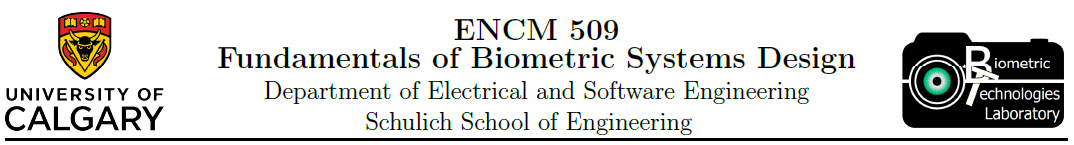

### Based heavily on ENCM-509's Lab 7 notebook

In [1]:
import pandas as pd
import numpy as np

#import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join, dirname, abspath
from tensorflow.keras.metrics import Precision, Recall
from warnings import simplefilter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# the length of records (if shorter, we need to add some zero rows)
NUMBER_TIMESTEPS = 150
# the number of features (from the data)
NUMBER_FEATURES = 203
# the number of classes/gestures
NUMBER_OUTPUTS = 3
# you can encode more than 1 but for this example we have binary output (circle/swipe)

In [3]:
# the directory where your data is
mypath_RO = '../data/genuine/RO'
mypath_imposter = '../data/imposter'
mypath_MA = '../data/genuine/MA'

# creating a list with all the filenames
datafiles_RO = [f for f in listdir('../data/genuine/RO') if isfile(join(mypath_RO, f))]
datafiles_MA = [f for f in listdir('../data/genuine/MA') if isfile(join(mypath_MA, f))]
datafiles_imposter = [f for f in listdir('../data/imposter') if isfile(join(mypath_imposter, f))]
print(datafiles_MA)

['MA_left_1.csv', 'MA_left_10.csv', 'MA_left_2.csv', 'MA_left_3.csv', 'MA_left_4.csv', 'MA_left_5.csv', 'MA_left_6.csv', 'MA_left_7.csv', 'MA_left_8.csv', 'MA_left_9.csv', 'MA_right_1.csv', 'MA_right_10.csv', 'MA_right_2.csv', 'MA_right_3.csv', 'MA_right_4.csv', 'MA_right_5.csv', 'MA_right_6.csv', 'MA_right_7.csv', 'MA_right_8.csv', 'MA_right_9.csv']


In [4]:
# choose data we need
columns = ['handPalmPosition_X','handPalmPosition_Y','handPalmPosition_Z',
          'pitch', 'roll', 'yaw', 'GenuineRO', 'GenuineMA', 'imposter',
          'wristPosition_X', 'wristPosition_Y','wristPosition_Z',
          'elbowPosition_X', 'elbowPosition_Y', 'elbowPosition_Z', 'handType']

finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
bone_names = ['Metacarpal', 'Proximal', 'Intermediate', 'Distal']
    
for finger in finger_names:
    columns.append(finger + 'Length')
    columns.append(finger + 'Width')

for finger in finger_names:
    for bone in bone_names:
        columns.append(finger + bone + 'Start_X')
        columns.append(finger + bone + 'Start_Y')
        columns.append(finger + bone + 'Start_Z')
        columns.append(finger + bone + 'End_X')
        columns.append(finger + bone + 'End_Y')
        columns.append(finger + bone + 'End_Z')
        columns.append(finger + bone + 'Direction_X') 
        columns.append(finger + bone + 'Direction_Y') 
        columns.append(finger + bone + 'Direction_Z')   

In [5]:
columns_to_expand = [
    'handPalmPosition', 'wristPosition', 'elbowPosition',
    'ThumbMetacarpalStart', 'ThumbMetacarpalEnd', 'ThumbMetacarpalDirection',
    'ThumbProximalStart', 'ThumbProximalEnd', 'ThumbProximalDirection',
    'ThumbIntermediateStart', 'ThumbIntermediateEnd', 'ThumbIntermediateDirection',
    'ThumbDistalStart', 'ThumbDistalEnd', 'ThumbDistalDirection',
    'IndexMetacarpalStart', 'IndexMetacarpalEnd', 'IndexMetacarpalDirection',
    'IndexProximalStart', 'IndexProximalEnd', 'IndexProximalDirection',
    'IndexIntermediateStart', 'IndexIntermediateEnd', 'IndexIntermediateDirection',
    'IndexDistalStart', 'IndexDistalEnd', 'IndexDistalDirection',
    'MiddleMetacarpalStart', 'MiddleMetacarpalEnd', 'MiddleMetacarpalDirection',
    'MiddleProximalStart', 'MiddleProximalEnd', 'MiddleProximalDirection',
    'MiddleIntermediateStart', 'MiddleIntermediateEnd', 'MiddleIntermediateDirection',
    'MiddleDistalStart', 'MiddleDistalEnd', 'MiddleDistalDirection',
    'RingMetacarpalStart', 'RingMetacarpalEnd', 'RingMetacarpalDirection',
    'RingProximalStart', 'RingProximalEnd', 'RingProximalDirection',
    'RingIntermediateStart', 'RingIntermediateEnd', 'RingIntermediateDirection',
    'RingDistalStart', 'RingDistalEnd', 'RingDistalDirection',
    'PinkyMetacarpalStart', 'PinkyMetacarpalEnd', 'PinkyMetacarpalDirection',
    'PinkyProximalStart', 'PinkyProximalEnd', 'PinkyProximalDirection',
    'PinkyIntermediateStart', 'PinkyIntermediateEnd', 'PinkyIntermediateDirection',
    'PinkyDistalStart', 'PinkyDistalEnd', 'PinkyDistalDirection'
]

In [6]:
# We need to set some ground truth 

genuine_ro = [f for f in listdir('../data/genuine/RO') if isfile(join(mypath_RO, f))]
imposter = [f for f in listdir('../data/imposter') if isfile(join(mypath_imposter, f))]
genuine_ma = [f for f in listdir('../data/genuine/MA') if isfile(join(mypath_MA, f))]

for c in genuine_ro:
    relative_path = mypath_RO + '/' + c
    print(relative_path)
    tmp = pd.read_csv(relative_path)
    tmp['imposter'] = 0
    tmp['GenuineRO'] = 1
    tmp['GenuineMA'] = 0
    tmp.to_csv(path_or_buf=relative_path, index=False)

for c in genuine_ma:
    relative_path = mypath_MA + '/' + c
    print(relative_path)
    tmp = pd.read_csv(relative_path)
    tmp['imposter'] = 0
    tmp['GenuineRO'] = 0
    tmp['GenuineMA'] = 1
    tmp.to_csv(path_or_buf=relative_path, index=False)

for s in imposter:
    relative_path = mypath_imposter + '/' + s
    print(relative_path)
    tmp = pd.read_csv(relative_path)
    tmp['imposter'] = 1
    tmp['GenuineRO'] = 0
    tmp['GenuineMA'] = 0
    tmp.to_csv(path_or_buf=relative_path, index=False)

../data/genuine/RO/RO_left_1.csv
../data/genuine/RO/RO_left_10.csv
../data/genuine/RO/RO_left_2.csv
../data/genuine/RO/RO_left_3.csv
../data/genuine/RO/RO_left_4.csv
../data/genuine/RO/RO_left_5.csv
../data/genuine/RO/RO_left_6.csv
../data/genuine/RO/RO_left_7.csv
../data/genuine/RO/RO_left_8.csv
../data/genuine/RO/RO_left_9.csv
../data/genuine/RO/RO_right_1.csv
../data/genuine/RO/RO_right_10.csv
../data/genuine/RO/RO_right_2.csv
../data/genuine/RO/RO_right_3.csv
../data/genuine/RO/RO_right_4.csv
../data/genuine/RO/RO_right_5.csv
../data/genuine/RO/RO_right_6.csv
../data/genuine/RO/RO_right_7.csv
../data/genuine/RO/RO_right_8.csv
../data/genuine/RO/RO_right_9.csv
../data/genuine/MA/MA_left_1.csv
../data/genuine/MA/MA_left_10.csv
../data/genuine/MA/MA_left_2.csv
../data/genuine/MA/MA_left_3.csv
../data/genuine/MA/MA_left_4.csv
../data/genuine/MA/MA_left_5.csv
../data/genuine/MA/MA_left_6.csv
../data/genuine/MA/MA_left_7.csv
../data/genuine/MA/MA_left_8.csv
../data/genuine/MA/MA_left_9.c

In [7]:
def split_and_expand(df, column_name_prefix):
    columns = [f'{column_name_prefix}_{i}' for i in ['X', 'Y', 'Z']]
    df[columns] = df[column_name_prefix].str[1:-1].str.split(',', expand=True)
    df.drop(columns=[column_name_prefix], inplace=True)


In [8]:
# Features
x = []
# Labels
y = []

In [9]:
def process_data(datafiles, use_prerecorded=False, columns_to_expand=None, path='./'):
    num = 1  # Counter for saving files (if needed)
    
    for sample in datafiles:
        relative_path = path + '/' + f'/{sample}' if use_prerecorded else path + '/' + f'/{sample}'
        tmp = pd.read_csv(relative_path, usecols=columns if use_prerecorded else None)
        
        
        if 'handType' in tmp.columns:
            tmp['handType'] = tmp['handType'].replace({
                'Right hand': 1,
                'Left hand': 2
            }).fillna(0).astype(float)

        
        if not use_prerecorded and columns_to_expand:
            for col in columns_to_expand:
                split_and_expand(tmp, col)
        
        tmp.fillna(0, inplace=True)
        tmp.replace('', 0, inplace=True)
        # tmp = tmp.astype(float)
        
        print(f'{relative_path}\nsize raw = {tmp.shape}')
        tmp = tmp.reindex(range(NUMBER_TIMESTEPS), fill_value=0) if tmp.shape[0] < NUMBER_TIMESTEPS else tmp.head(NUMBER_TIMESTEPS)
        print(f'size normalized = {tmp.shape}')
        
        tmp_x = tmp.drop(columns=['GenuineRO', 'GenuineMA', 'imposter'], errors='ignore')
        tmp_x.drop(columns=[col for col in tmp_x.columns if col not in columns], inplace=True)
        tmp_y = tmp[['GenuineRO', 'GenuineMA', 'imposter']]
        
        if use_prerecorded:
            path_str = f'save/{num}.csv'
            # tmp_x.to_csv(path_str)
            num += 1
        
        x.append(tmp_x)
        y.append(tmp_y)

In [10]:
# Run with YOUR RECORDED DATA
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

process_data(datafiles_RO, use_prerecorded=False, columns_to_expand=columns_to_expand, path=mypath_RO)
process_data(datafiles_MA, use_prerecorded=False, columns_to_expand=columns_to_expand, path=mypath_MA)
process_data(datafiles_imposter, use_prerecorded=False, columns_to_expand=columns_to_expand, path=mypath_imposter)


../data/genuine/RO//RO_left_1.csv
size raw = (129, 236)
size normalized = (150, 236)
../data/genuine/RO//RO_left_10.csv
size raw = (138, 236)
size normalized = (150, 236)
../data/genuine/RO//RO_left_2.csv
size raw = (119, 236)
size normalized = (150, 236)
../data/genuine/RO//RO_left_3.csv
size raw = (127, 236)
size normalized = (150, 236)
../data/genuine/RO//RO_left_4.csv
size raw = (127, 236)
size normalized = (150, 236)
../data/genuine/RO//RO_left_5.csv
size raw = (129, 236)
size normalized = (150, 236)
../data/genuine/RO//RO_left_6.csv
size raw = (116, 236)
size normalized = (150, 236)
../data/genuine/RO//RO_left_7.csv
size raw = (120, 236)
size normalized = (150, 236)
../data/genuine/RO//RO_left_8.csv
size raw = (153, 236)
size normalized = (150, 236)
../data/genuine/RO//RO_left_9.csv
size raw = (121, 236)
size normalized = (150, 236)
../data/genuine/RO//RO_right_1.csv
size raw = (176, 236)
size normalized = (150, 236)
../data/genuine/RO//RO_right_10.csv
size raw = (110, 236)
size 

# Classification


In [11]:
np.array(y[0].loc[0])

array([1, 0, 0], dtype=int64)

In [12]:
# Each sample requires labels of [1,NUMBER_OUTPUTS] size (not a list)
y_new = list()
for cur_label in y:
    tmp = np.array(cur_label.loc[0])
    y_new.append(tmp)
y = np.array(y_new)
#print(y)

In [13]:
# Set a percentage of test set fraction
test_size = 0.20 # 20%

# Divide data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=True, stratify=y)
len_train = len(X_train)
len_test = len(X_test)

print ('Number of train samples = {}\nNumber of test samples = {}'.format(len_train, len_test))
print ('There is ',type(X_train),' of ',type(X_train[0]))

# Turn list(DataFrame) into numpy.ndarray with [len_train, NUMBER_TIMESTEPS, NUMBER_FEATURES]
X_train = np.array(X_train, dtype=float)
X_test = np.array(X_test, dtype=float)
print('The list was turned into <numpy.ndarray>')

Number of train samples = 63
Number of test samples = 16
There is  <class 'list'>  of  <class 'pandas.core.frame.DataFrame'>
The list was turned into <numpy.ndarray>


In [14]:
NUMBER_TIMESTEPS = 150
# Change this number if you record your data and have longer record.
# this is the number of rows in the data file which include useful information

def build_model():
    model = models.Sequential()
    
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.LSTM(256, return_sequences=True, recurrent_dropout=0.2))
    model.add(layers.LSTM(128, recurrent_dropout=0.2))
    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(NUMBER_OUTPUTS, activation='softmax'))

    opt = Adam(learning_rate=0.002)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', Precision(), Recall()])
    return model


In [15]:
# creating the model
model = build_model()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 148, 64)           39040     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 74, 256)           328704    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                          

In [17]:
# training the model
early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,                # how many epochs to wait before stopping
    restore_best_weights=True # restores the best weights seen during training
)

history = model.fit(X_train, y_train, epochs=100, batch_size=len_train, callbacks=[early_stopping])

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 1.3251 - accuracy: 0.2857 - precision: 0.2581 - recall: 0.1270
Epoch 2/100
1/1 [==============================] - 0s 374ms/step - loss: 0.9274 - accuracy: 0.5238 - precision: 0.5556 - recall: 0.3175
Epoch 3/100
1/1 [==============================] - 0s 346ms/step - loss: 0.8746 - accuracy: 0.5714 - precision: 0.6250 - recall: 0.4762
Epoch 4/100
1/1 [==============================] - 0s 361ms/step - loss: 0.7744 - accuracy: 0.6349 - precision: 0.6481 - recall: 0.5556
Epoch 5/100
1/1 [==============================] - 0s 349ms/step - loss: 0.8348 - accuracy: 0.5873 - precision: 0.6296 - recall: 0.5397
Epoch 6/100
1/1 [==============================] - 0s 349ms/step - loss: 0.8175 - accuracy: 0.6190 - precision: 0.6364 - recall: 0.5556
Epoch 7/100
1/1 [==============================] - 0s 356ms/step - loss: 0.5602 - accuracy: 0.7778 - precision: 0.7966 - recall: 0.7460
Epoch 8/100
1/1 [==============================] - 

In [18]:
train_loss, train_acc, train_precision, train_recall = model.evaluate(X_train, y_train, batch_size=len_train)

1/1 [==============================] - 1s 707ms/step - loss: 0.7945 - accuracy: 0.8730 - precision: 0.9524 - recall: 0.3175


In [19]:
# testing the model
test_loss, test_acc, percision, recall = model.evaluate(X_test, y_test, batch_size=len_test)

1/1 [==============================] - 1s 672ms/step - loss: 0.8446 - accuracy: 0.8125 - precision: 1.0000 - recall: 0.3125


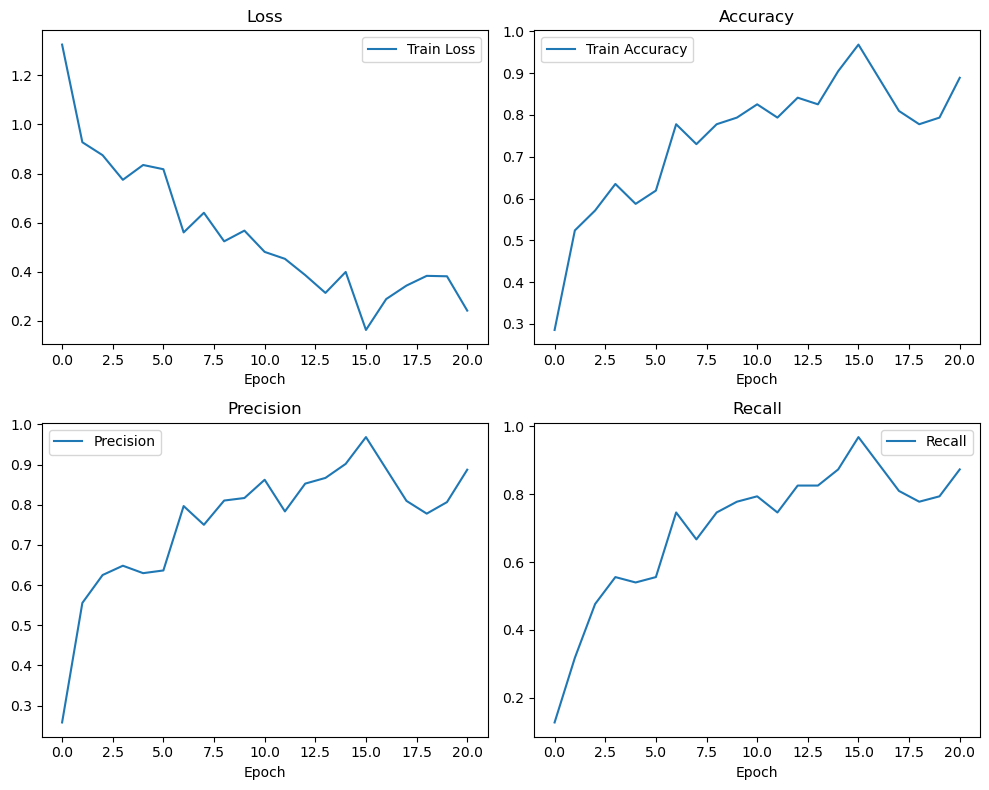

In [20]:
# VISUAL: Training Curves (2x2 Grid)
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Precision')
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Recall')
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
y_probs  = model.predict(X_test)
y_pred = np.zeros_like(y_probs)
y_pred[np.arange(len(y_probs)), y_probs.argmax(1)] = 1

1/1 [==============================] - 1s 617ms/step


In [22]:
matches = np.all(y_pred == y_test, axis=1)  # Boolean array
total_matches = matches.sum()
match_rate = total_matches / float(len(matches))

print('Total matches: %d' % total_matches)
print('Match rate: %.2f' % match_rate)

Total matches: 13
Match rate: 0.81


In [23]:
# uncommment to save model to be used for classification in the authenticator code
# model.save("../model/gesture_model_all_data.h5")

1/1 [==============================] - 0s 75ms/step


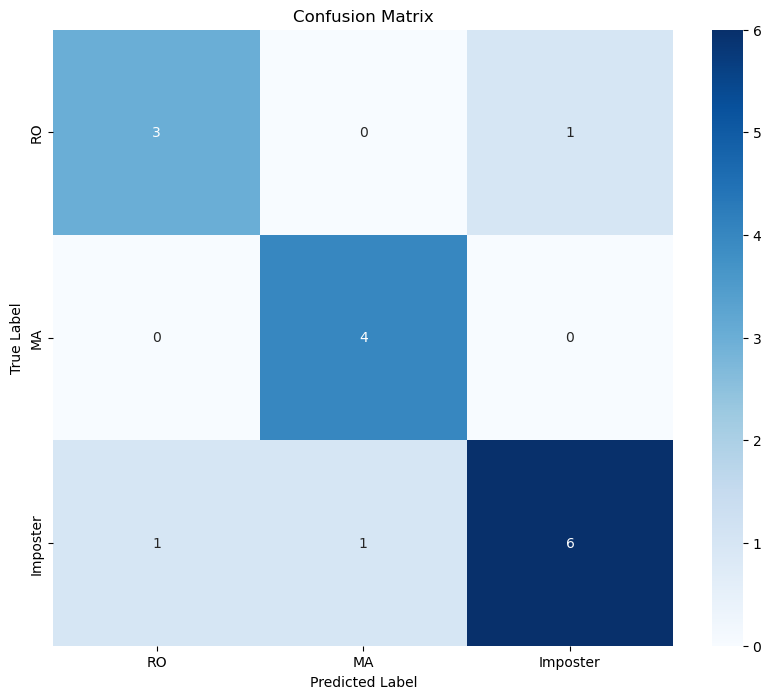

In [24]:
# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['RO', 'MA', 'Imposter']

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 70ms/step


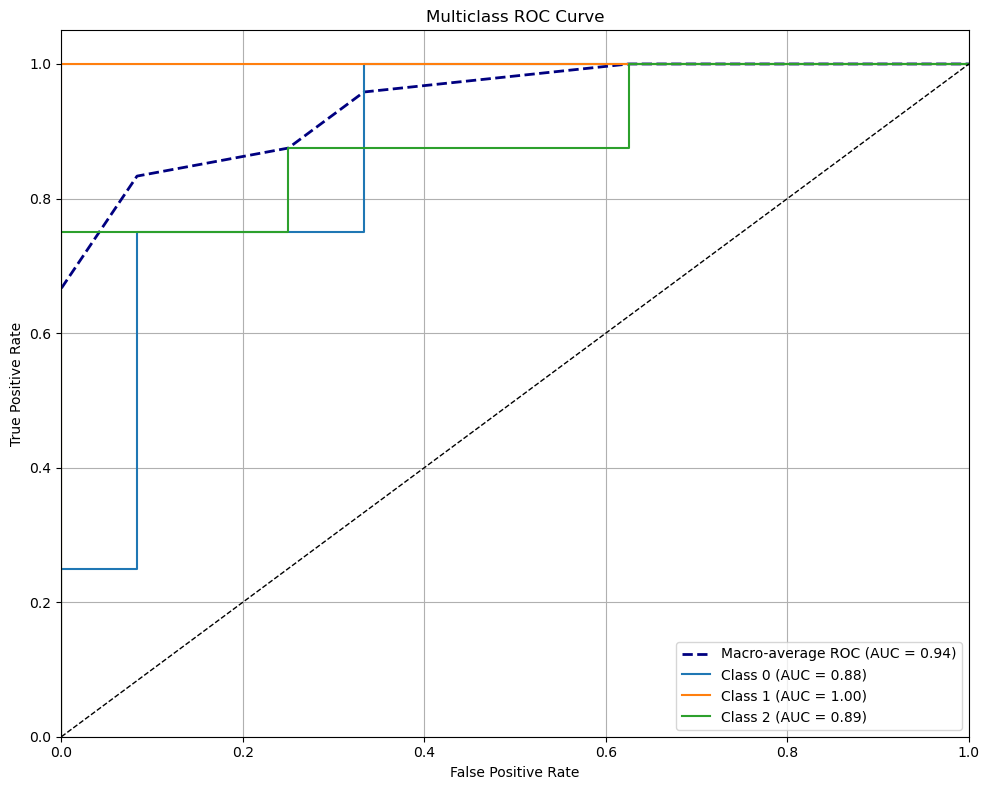

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict class probabilities (softmax output)
y_score = model.predict(X_test)   # shape: (num_samples, num_classes)

# y_test is already one-hot encoded, so keep it as is
n_classes = y_test.shape[1]

# Compute ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plotting
plt.figure(figsize=(10, 8))

# Macro-average
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC (AUC = {:.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle='--', linewidth=2)

# Per-class curves
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
